# LSTM Travel Time + Speed Prediction - N103.1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N103.1')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6391,65,21,2021042800
6405,65,21,2021042800
6419,65,21,2021042800
6433,65,21,2021042800
6447,65,21,2021042800
...,...,...,...
294416,64,21,2021051509
294430,64,21,2021051509
294444,64,21,2021051509
294458,64,21,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,65.0,21.0
2021042801,65.0,21.0
2021042802,65.0,21.0
2021042803,65.0,21.0
2021042804,65.0,21.0
...,...,...
2021051505,64.0,21.0
2021051506,64.0,21.0
2021051507,64.0,21.0


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,0.906593
2021051506,0.906593
2021051507,0.906593


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1],1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# LSTM - Time

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 13s 1s/step - loss: 0.9734 - mae: 0.9627 - rmse: 0.9703 - val_loss: 0.9414 - val_mae: 0.9414 - val_rmse: 0.9414
Epoch 2/300
3/3 [==============================] - 0s 110ms/step - loss: 0.9045 - mae: 0.8920 - rmse: 0.9044 - val_loss: 0.8818 - val_mae: 0.8818 - val_rmse: 0.8818
Epoch 3/300
3/3 [==============================] - 0s 103ms/step - loss: 0.8416 - mae: 0.8294 - rmse: 0.8421 - val_loss: 0.8261 - val_mae: 0.8261 - val_rmse: 0.8261
Epoch 4/300
3/3 [==============================] - 0s 110ms/step - loss: 0.7861 - mae: 0.7734 - rmse: 0.7922 - val_loss: 0.7740 - val_mae: 0.7740 - val_rmse: 0.7740
Epoch 5/300
3/3 [==============================] - 0s 117ms/step - loss: 0.7462 - mae: 0.7288 - rmse: 0.7495 - val_loss: 0.7261 - val_mae: 0.7261 - val_rmse: 0.7261
Epoch 6/300
3/3 [==============================] - 0s 105ms/step - loss: 0.6868 - mae: 0.6716 - rmse: 0.6875 - val_loss: 0.6808 - val_mae: 0.6808 - val_rmse: 0.6808
Epoch 7/300


3/3 [==============================] - 0s 121ms/step - loss: 0.1276 - mae: 0.0926 - rmse: 0.1206 - val_loss: 0.0623 - val_mae: 0.0623 - val_rmse: 0.0623
Epoch 51/300
3/3 [==============================] - 0s 116ms/step - loss: 0.1299 - mae: 0.0945 - rmse: 0.1226 - val_loss: 0.0606 - val_mae: 0.0606 - val_rmse: 0.0606
Epoch 52/300
3/3 [==============================] - 0s 107ms/step - loss: 0.1210 - mae: 0.0950 - rmse: 0.1165 - val_loss: 0.0590 - val_mae: 0.0590 - val_rmse: 0.0590
Epoch 53/300
3/3 [==============================] - 0s 99ms/step - loss: 0.1417 - mae: 0.1008 - rmse: 0.1347 - val_loss: 0.0570 - val_mae: 0.0570 - val_rmse: 0.0570
Epoch 54/300
3/3 [==============================] - 0s 120ms/step - loss: 0.1371 - mae: 0.0976 - rmse: 0.1288 - val_loss: 0.0553 - val_mae: 0.0553 - val_rmse: 0.0553
Epoch 55/300
3/3 [==============================] - 0s 108ms/step - loss: 0.1275 - mae: 0.0900 - rmse: 0.1187 - val_loss: 0.0540 - val_mae: 0.0540 - val_rmse: 0.0540
Epoch 56/300
3/3 [

3/3 [==============================] - 0s 113ms/step - loss: 0.1216 - mae: 0.0687 - rmse: 0.1095 - val_loss: 0.0251 - val_mae: 0.0251 - val_rmse: 0.0251
Epoch 100/300
3/3 [==============================] - 0s 105ms/step - loss: 0.1238 - mae: 0.0686 - rmse: 0.1126 - val_loss: 0.0249 - val_mae: 0.0249 - val_rmse: 0.0249
Epoch 101/300
3/3 [==============================] - 0s 111ms/step - loss: 0.1272 - mae: 0.0671 - rmse: 0.1156 - val_loss: 0.0246 - val_mae: 0.0246 - val_rmse: 0.0246
Epoch 102/300
3/3 [==============================] - 0s 115ms/step - loss: 0.1246 - mae: 0.0637 - rmse: 0.1169 - val_loss: 0.0242 - val_mae: 0.0242 - val_rmse: 0.0242
Epoch 103/300
3/3 [==============================] - 0s 106ms/step - loss: 0.1224 - mae: 0.0655 - rmse: 0.1120 - val_loss: 0.0240 - val_mae: 0.0240 - val_rmse: 0.0240
Epoch 104/300
3/3 [==============================] - 0s 106ms/step - loss: 0.1248 - mae: 0.0674 - rmse: 0.1140 - val_loss: 0.0237 - val_mae: 0.0237 - val_rmse: 0.0237
Epoch 105/30

3/3 [==============================] - 0s 131ms/step - loss: 0.1213 - mae: 0.0554 - rmse: 0.1107 - val_loss: 0.0162 - val_mae: 0.0162 - val_rmse: 0.0162
Epoch 149/300
3/3 [==============================] - 0s 132ms/step - loss: 0.1257 - mae: 0.0577 - rmse: 0.1133 - val_loss: 0.0161 - val_mae: 0.0161 - val_rmse: 0.0161
Epoch 150/300
3/3 [==============================] - 0s 99ms/step - loss: 0.1251 - mae: 0.0628 - rmse: 0.1157 - val_loss: 0.0159 - val_mae: 0.0159 - val_rmse: 0.0159
Epoch 151/300
3/3 [==============================] - 0s 125ms/step - loss: 0.1224 - mae: 0.0592 - rmse: 0.1108 - val_loss: 0.0158 - val_mae: 0.0158 - val_rmse: 0.0158
Epoch 152/300
3/3 [==============================] - 0s 108ms/step - loss: 0.1249 - mae: 0.0618 - rmse: 0.1140 - val_loss: 0.0157 - val_mae: 0.0157 - val_rmse: 0.0157
Epoch 153/300
3/3 [==============================] - 0s 94ms/step - loss: 0.1234 - mae: 0.0592 - rmse: 0.1117 - val_loss: 0.0156 - val_mae: 0.0156 - val_rmse: 0.0156
Epoch 154/300


3/3 [==============================] - 0s 188ms/step - loss: 0.1256 - mae: 0.0551 - rmse: 0.1122 - val_loss: 0.0122 - val_mae: 0.0122 - val_rmse: 0.0122
Epoch 198/300
3/3 [==============================] - 0s 144ms/step - loss: 0.1256 - mae: 0.0555 - rmse: 0.1135 - val_loss: 0.0121 - val_mae: 0.0121 - val_rmse: 0.0121
Epoch 199/300
3/3 [==============================] - 0s 162ms/step - loss: 0.1245 - mae: 0.0538 - rmse: 0.1116 - val_loss: 0.0120 - val_mae: 0.0120 - val_rmse: 0.0120
Epoch 200/300
3/3 [==============================] - 0s 165ms/step - loss: 0.1254 - mae: 0.0538 - rmse: 0.1128 - val_loss: 0.0120 - val_mae: 0.0120 - val_rmse: 0.0120
Epoch 201/300
3/3 [==============================] - 0s 115ms/step - loss: 0.1250 - mae: 0.0543 - rmse: 0.1124 - val_loss: 0.0119 - val_mae: 0.0119 - val_rmse: 0.0119
Epoch 202/300
3/3 [==============================] - 0s 113ms/step - loss: 0.1264 - mae: 0.0553 - rmse: 0.1126 - val_loss: 0.0119 - val_mae: 0.0119 - val_rmse: 0.0119
Epoch 203/30

3/3 [==============================] - 1s 232ms/step - loss: 0.1241 - mae: 0.0543 - rmse: 0.1111 - val_loss: 0.0097 - val_mae: 0.0097 - val_rmse: 0.0097
Epoch 247/300
3/3 [==============================] - 0s 138ms/step - loss: 0.1258 - mae: 0.0538 - rmse: 0.1124 - val_loss: 0.0097 - val_mae: 0.0097 - val_rmse: 0.0097
Epoch 248/300
3/3 [==============================] - 0s 201ms/step - loss: 0.1252 - mae: 0.0524 - rmse: 0.1131 - val_loss: 0.0096 - val_mae: 0.0096 - val_rmse: 0.0096
Epoch 249/300
3/3 [==============================] - 0s 122ms/step - loss: 0.1247 - mae: 0.0522 - rmse: 0.1133 - val_loss: 0.0096 - val_mae: 0.0096 - val_rmse: 0.0096
Epoch 250/300
3/3 [==============================] - 0s 113ms/step - loss: 0.1230 - mae: 0.0514 - rmse: 0.1114 - val_loss: 0.0095 - val_mae: 0.0095 - val_rmse: 0.0095
Epoch 251/300
3/3 [==============================] - 1s 234ms/step - loss: 0.1247 - mae: 0.0532 - rmse: 0.1114 - val_loss: 0.0095 - val_mae: 0.0095 - val_rmse: 0.0095
Epoch 252/30

3/3 [==============================] - 0s 94ms/step - loss: 0.1237 - mae: 0.0505 - rmse: 0.1109 - val_loss: 0.0080 - val_mae: 0.0080 - val_rmse: 0.0080
Epoch 296/300
3/3 [==============================] - 0s 110ms/step - loss: 0.1266 - mae: 0.0520 - rmse: 0.1143 - val_loss: 0.0080 - val_mae: 0.0080 - val_rmse: 0.0080
Epoch 297/300
3/3 [==============================] - 0s 107ms/step - loss: 0.1257 - mae: 0.0515 - rmse: 0.1122 - val_loss: 0.0080 - val_mae: 0.0080 - val_rmse: 0.0080
Epoch 298/300
3/3 [==============================] - 0s 106ms/step - loss: 0.1253 - mae: 0.0516 - rmse: 0.1127 - val_loss: 0.0079 - val_mae: 0.0079 - val_rmse: 0.0079
Epoch 299/300
3/3 [==============================] - 0s 107ms/step - loss: 0.1252 - mae: 0.0540 - rmse: 0.1123 - val_loss: 0.0079 - val_mae: 0.0079 - val_rmse: 0.0079
Epoch 300/300
3/3 [==============================] - 0s 100ms/step - loss: 0.1253 - mae: 0.0522 - rmse: 0.1128 - val_loss: 0.0078 - val_mae: 0.0078 - val_rmse: 0.0078
dict_keys(['l

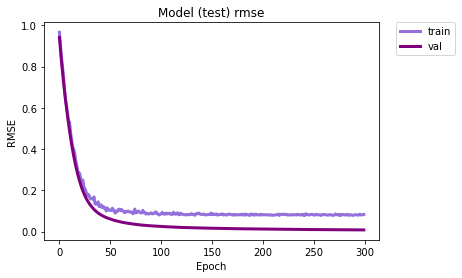

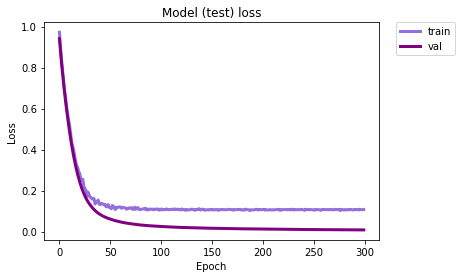

Epoch 1/300
5/5 [==============================] - 0s 106ms/step - loss: 0.0939 - mae: 0.0407 - rmse: 0.0825 - val_loss: 0.2097 - val_mae: 0.0585 - val_rmse: 0.2097
Epoch 2/300
5/5 [==============================] - 0s 82ms/step - loss: 0.0933 - mae: 0.0400 - rmse: 0.0812 - val_loss: 0.2097 - val_mae: 0.0584 - val_rmse: 0.2097
Epoch 3/300
5/5 [==============================] - 0s 101ms/step - loss: 0.0940 - mae: 0.0399 - rmse: 0.0813 - val_loss: 0.2097 - val_mae: 0.0584 - val_rmse: 0.2097
Epoch 4/300
5/5 [==============================] - 0s 91ms/step - loss: 0.0937 - mae: 0.0399 - rmse: 0.0812 - val_loss: 0.2097 - val_mae: 0.0584 - val_rmse: 0.2097
Epoch 5/300
5/5 [==============================] - 0s 97ms/step - loss: 0.0929 - mae: 0.0393 - rmse: 0.0815 - val_loss: 0.2098 - val_mae: 0.0584 - val_rmse: 0.2098
Epoch 6/300
5/5 [==============================] - 0s 102ms/step - loss: 0.0926 - mae: 0.0393 - rmse: 0.0800 - val_loss: 0.2098 - val_mae: 0.0583 - val_rmse: 0.2098
Epoch 7/300
5

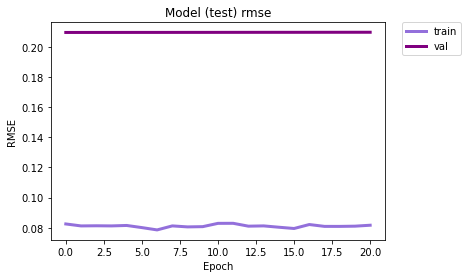

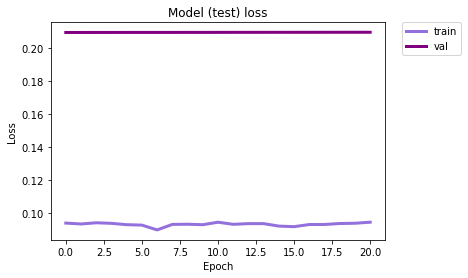

Epoch 1/300
7/7 [==============================] - 1s 94ms/step - loss: 0.1140 - mae: 0.0433 - rmse: 0.1194 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 2/300
7/7 [==============================] - 1s 75ms/step - loss: 0.1147 - mae: 0.0441 - rmse: 0.1202 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 3/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1143 - mae: 0.0427 - rmse: 0.1194 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 4/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1150 - mae: 0.0431 - rmse: 0.1202 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 5/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1133 - mae: 0.0431 - rmse: 0.1188 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 6/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1146 - mae: 0.0439 - rmse: 0.1202 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 1s 78ms/step - loss: 0.1145 - mae: 0.0442 - rmse: 0.1199 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 52/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1157 - mae: 0.0446 - rmse: 0.1209 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 53/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1137 - mae: 0.0436 - rmse: 0.1195 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 54/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1139 - mae: 0.0438 - rmse: 0.1194 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 55/300
7/7 [==============================] - 1s 94ms/step - loss: 0.1147 - mae: 0.0430 - rmse: 0.1201 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 56/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1146 - mae: 0.0448 - rmse: 0.1193 - val_loss: 0.1238 - val_mae: 0.0559 - val_rmse: 0.0711
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 1s 92ms/step - loss: 0.1149 - mae: 0.0442 - rmse: 0.1201 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoch 102/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1133 - mae: 0.0428 - rmse: 0.1191 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoch 103/300
7/7 [==============================] - 1s 94ms/step - loss: 0.1137 - mae: 0.0438 - rmse: 0.1192 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoch 104/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1140 - mae: 0.0438 - rmse: 0.1196 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoch 105/300
7/7 [==============================] - 1s 98ms/step - loss: 0.1136 - mae: 0.0434 - rmse: 0.1192 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoch 106/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1151 - mae: 0.0437 - rmse: 0.1203 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0711
Epoc

7/7 [==============================] - 1s 77ms/step - loss: 0.1153 - mae: 0.0441 - rmse: 0.1208 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 151/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1145 - mae: 0.0429 - rmse: 0.1200 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 152/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1149 - mae: 0.0438 - rmse: 0.1202 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 153/300
7/7 [==============================] - 0s 60ms/step - loss: 0.1132 - mae: 0.0424 - rmse: 0.1188 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 154/300
7/7 [==============================] - 0s 59ms/step - loss: 0.1148 - mae: 0.0442 - rmse: 0.1202 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 155/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1139 - mae: 0.0429 - rmse: 0.1196 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 156/300
7/7 

7/7 [==============================] - 1s 88ms/step - loss: 0.1136 - mae: 0.0430 - rmse: 0.1192 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 200/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1153 - mae: 0.0440 - rmse: 0.1208 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 201/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1149 - mae: 0.0444 - rmse: 0.1201 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 202/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1147 - mae: 0.0444 - rmse: 0.1203 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 203/300
7/7 [==============================] - 1s 92ms/step - loss: 0.1139 - mae: 0.0435 - rmse: 0.1196 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 204/300
7/7 [==============================] - 0s 73ms/step - loss: 0.1134 - mae: 0.0436 - rmse: 0.1192 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 205/300
7/7 

7/7 [==============================] - 1s 88ms/step - loss: 0.1143 - mae: 0.0438 - rmse: 0.1198 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 249/300
7/7 [==============================] - 1s 76ms/step - loss: 0.1140 - mae: 0.0435 - rmse: 0.1187 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 250/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1138 - mae: 0.0434 - rmse: 0.1193 - val_loss: 0.1238 - val_mae: 0.0560 - val_rmse: 0.0712
Epoch 251/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1141 - mae: 0.0436 - rmse: 0.1195 - val_loss: 0.1238 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 252/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1144 - mae: 0.0434 - rmse: 0.1195 - val_loss: 0.1238 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 253/300
7/7 [==============================] - 1s 109ms/step - loss: 0.1148 - mae: 0.0443 - rmse: 0.1205 - val_loss: 0.1238 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 254/300
7/7

7/7 [==============================] - 1s 109ms/step - loss: 0.1149 - mae: 0.0441 - rmse: 0.1205 - val_loss: 0.1238 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 298/300
7/7 [==============================] - 1s 123ms/step - loss: 0.1138 - mae: 0.0430 - rmse: 0.1191 - val_loss: 0.1237 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 299/300
7/7 [==============================] - 1s 116ms/step - loss: 0.1133 - mae: 0.0442 - rmse: 0.1191 - val_loss: 0.1237 - val_mae: 0.0561 - val_rmse: 0.0712
Epoch 300/300
7/7 [==============================] - 1s 140ms/step - loss: 0.1147 - mae: 0.0437 - rmse: 0.1201 - val_loss: 0.1237 - val_mae: 0.0561 - val_rmse: 0.0712
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


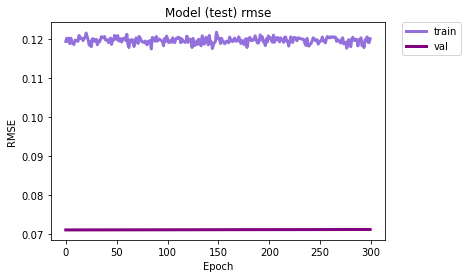

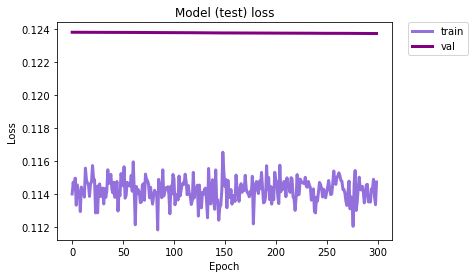

Epoch 1/300
9/9 [==============================] - 1s 161ms/step - loss: 0.1077 - mae: 0.0413 - rmse: 0.1009 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 2/300
9/9 [==============================] - 1s 98ms/step - loss: 0.1084 - mae: 0.0432 - rmse: 0.1018 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 3/300
9/9 [==============================] - 1s 95ms/step - loss: 0.1078 - mae: 0.0423 - rmse: 0.1003 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 4/300
9/9 [==============================] - 1s 113ms/step - loss: 0.1091 - mae: 0.0421 - rmse: 0.1021 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 5/300
9/9 [==============================] - 1s 110ms/step - loss: 0.1076 - mae: 0.0426 - rmse: 0.1006 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 6/300
9/9 [==============================] - 1s 97ms/step - loss: 0.1089 - mae: 0.0430 - rmse: 0.1020 - val_loss: 0.1545 - val_mae: 0.0645 - val_rmse: 0.2378
Epoch 7/300
9

9/9 [==============================] - 1s 84ms/step - loss: 0.1092 - mae: 0.0441 - rmse: 0.1019 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 51/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1075 - mae: 0.0418 - rmse: 0.1001 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 52/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1088 - mae: 0.0437 - rmse: 0.1014 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 53/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1091 - mae: 0.0429 - rmse: 0.1025 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 54/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1086 - mae: 0.0431 - rmse: 0.1014 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 55/300
9/9 [==============================] - 1s 116ms/step - loss: 0.1094 - mae: 0.0427 - rmse: 0.1020 - val_loss: 0.1545 - val_mae: 0.0644 - val_rmse: 0.2378
Epoch 56/300
9/9 [====

9/9 [==============================] - 1s 148ms/step - loss: 0.1079 - mae: 0.0415 - rmse: 0.1009 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 100/300
9/9 [==============================] - 1s 127ms/step - loss: 0.1083 - mae: 0.0425 - rmse: 0.1011 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 101/300
9/9 [==============================] - 1s 138ms/step - loss: 0.1084 - mae: 0.0427 - rmse: 0.1013 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 102/300
9/9 [==============================] - 1s 108ms/step - loss: 0.1086 - mae: 0.0424 - rmse: 0.1015 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 103/300
9/9 [==============================] - 1s 110ms/step - loss: 0.1090 - mae: 0.0434 - rmse: 0.1022 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 104/300
9/9 [==============================] - 1s 107ms/step - loss: 0.1089 - mae: 0.0422 - rmse: 0.1015 - val_loss: 0.1545 - val_mae: 0.0643 - val_rmse: 0.2378
Epoch 105/30

9/9 [==============================] - 1s 133ms/step - loss: 0.1085 - mae: 0.0425 - rmse: 0.1013 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 149/300
9/9 [==============================] - 1s 131ms/step - loss: 0.1090 - mae: 0.0423 - rmse: 0.1023 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 150/300
9/9 [==============================] - 1s 131ms/step - loss: 0.1093 - mae: 0.0417 - rmse: 0.1021 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 151/300
9/9 [==============================] - 1s 129ms/step - loss: 0.1087 - mae: 0.0422 - rmse: 0.1018 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 152/300
9/9 [==============================] - 1s 118ms/step - loss: 0.1080 - mae: 0.0430 - rmse: 0.1012 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 153/300
9/9 [==============================] - 1s 155ms/step - loss: 0.1086 - mae: 0.0426 - rmse: 0.1016 - val_loss: 0.1545 - val_mae: 0.0642 - val_rmse: 0.2378
Epoch 154/30

9/9 [==============================] - 1s 136ms/step - loss: 0.1092 - mae: 0.0420 - rmse: 0.1020 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 197/300
9/9 [==============================] - 1s 124ms/step - loss: 0.1096 - mae: 0.0429 - rmse: 0.1025 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 198/300
9/9 [==============================] - 1s 164ms/step - loss: 0.1090 - mae: 0.0427 - rmse: 0.1023 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 199/300
9/9 [==============================] - 1s 150ms/step - loss: 0.1091 - mae: 0.0423 - rmse: 0.1016 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 200/300
9/9 [==============================] - 1s 130ms/step - loss: 0.1084 - mae: 0.0424 - rmse: 0.1015 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 201/300
9/9 [==============================] - 1s 165ms/step - loss: 0.1088 - mae: 0.0424 - rmse: 0.1019 - val_loss: 0.1544 - val_mae: 0.0641 - val_rmse: 0.2378
Epoch 202/30

9/9 [==============================] - 1s 87ms/step - loss: 0.1085 - mae: 0.0419 - rmse: 0.1019 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 246/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1090 - mae: 0.0431 - rmse: 0.1021 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 247/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1090 - mae: 0.0435 - rmse: 0.1018 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 248/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1089 - mae: 0.0426 - rmse: 0.1017 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 249/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1083 - mae: 0.0417 - rmse: 0.1014 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 250/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1093 - mae: 0.0432 - rmse: 0.1027 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 251/300
9/9 

9/9 [==============================] - 1s 82ms/step - loss: 0.1087 - mae: 0.0422 - rmse: 0.1013 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 295/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1085 - mae: 0.0419 - rmse: 0.1013 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 296/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1080 - mae: 0.0422 - rmse: 0.1007 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 297/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1080 - mae: 0.0414 - rmse: 0.1009 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 298/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1094 - mae: 0.0419 - rmse: 0.1021 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 299/300
9/9 [==============================] - 1s 77ms/step - loss: 0.1085 - mae: 0.0426 - rmse: 0.1014 - val_loss: 0.1544 - val_mae: 0.0640 - val_rmse: 0.2378
Epoch 300/300
9/9 

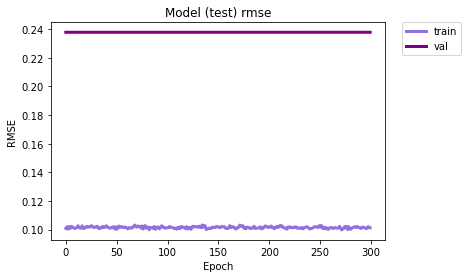

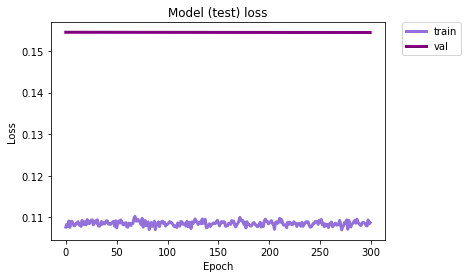

Epoch 1/300
11/11 [==============================] - 1s 88ms/step - loss: 0.1192 - mae: 0.0443 - rmse: 0.1130 - val_loss: 0.4789 - val_mae: 0.1737 - val_rmse: 0.4681
Epoch 2/300
11/11 [==============================] - 1s 78ms/step - loss: 0.1191 - mae: 0.0435 - rmse: 0.1131 - val_loss: 0.4789 - val_mae: 0.1737 - val_rmse: 0.4681
Epoch 3/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1182 - mae: 0.0440 - rmse: 0.1121 - val_loss: 0.4789 - val_mae: 0.1737 - val_rmse: 0.4681
Epoch 4/300
11/11 [==============================] - 1s 65ms/step - loss: 0.1189 - mae: 0.0435 - rmse: 0.1133 - val_loss: 0.4789 - val_mae: 0.1736 - val_rmse: 0.4681
Epoch 5/300
11/11 [==============================] - 1s 72ms/step - loss: 0.1187 - mae: 0.0436 - rmse: 0.1125 - val_loss: 0.4789 - val_mae: 0.1736 - val_rmse: 0.4681
Epoch 6/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1196 - mae: 0.0447 - rmse: 0.1134 - val_loss: 0.4789 - val_mae: 0.1736 - val_rmse: 0.4681
Epoc

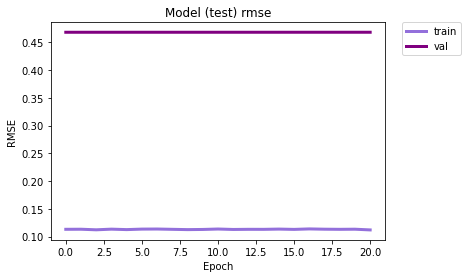

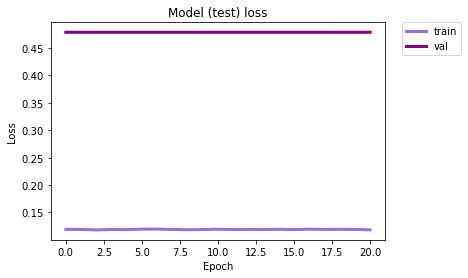

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9923491
Transformed yhat 43.670147
yhat -0.9923797
Transformed yhat 43.669815
yhat -0.9924045
Transformed yhat 43.669548
yhat -0.992425
Transformed yhat 43.66933
yhat -0.9924416
Transformed yhat 43.669155
yhat -0.9924551
Transformed yhat 43.669006
yhat -0.99246615
Transformed yhat 43.66889
yhat -0.99248207
Transformed yhat 43.668724
yhat -0.9925663
Transformed yhat 43.66782
yhat -0.9925886
Transformed yhat 43.66758
yhat -0.9925816
Transformed yhat 43.667656
yhat -0.9925753
Transformed yhat 43.66772
Real data: [43.58823529 43.58823529 43.58823529 43.58823529 43.58823529 43.58823529
 43.99335783 48.22377198 45.18621862 43.58823529 43.58823529 43.58823529
 43.58823529 43.58823529 43.58823529 43.58823529 43.58823529 43.58823529
 43.58823529 43.58823529 43.58823529 43.58823529 43.58823529 43.58823529]
Forecasting values: [43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7, 43.7]


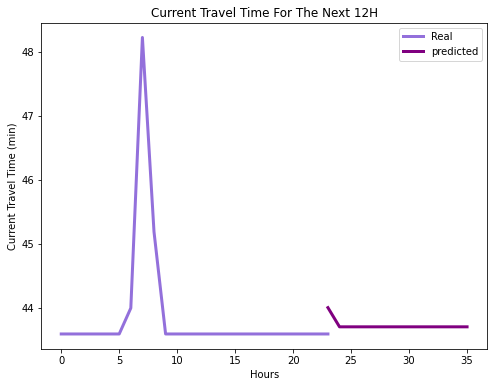

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.1',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 7s 663ms/step - loss: 0.8241 - mae: 0.8045 - rmse: 0.8229 - val_loss: 0.7449 - val_mae: 0.7449 - val_rmse: 0.7449
Epoch 2/300
3/3 [==============================] - 0s 69ms/step - loss: 0.7448 - mae: 0.7233 - rmse: 0.7447 - val_loss: 0.6735 - val_mae: 0.6735 - val_rmse: 0.6735
Epoch 3/300
3/3 [==============================] - 0s 68ms/step - loss: 0.6719 - mae: 0.6514 - rmse: 0.6703 - val_loss: 0.6076 - val_mae: 0.6076 - val_rmse: 0.6076
Epoch 4/300
3/3 [==============================] - 0s 65ms/step - loss: 0.6054 - mae: 0.5892 - rmse: 0.6080 - val_loss: 0.5495 - val_mae: 0.5495 - val_rmse: 0.5495
Epoch 5/300
3/3 [==============================] - 0s 70ms/step - loss: 0.5654 - mae: 0.5511 - rmse: 0.5644 - val_loss: 0.4991 - val_mae: 0.4991 - val_rmse: 0.4991
Epoch 6/300
3/3 [==============================] - 0s 67ms/step - loss: 0.5111 - mae: 0.4962 - rmse: 0.5048 - val_loss: 0.4500 - val_mae: 0.4500 - val_rmse: 0.4500
Epoch 7/300
3/3

Epoch 51/300
3/3 [==============================] - 0s 86ms/step - loss: 0.2166 - mae: 0.1163 - rmse: 0.1951 - val_loss: 2.3433e-04 - val_mae: 1.9077e-04 - val_rmse: 2.3433e-04
Epoch 52/300
3/3 [==============================] - 0s 72ms/step - loss: 0.2107 - mae: 0.1149 - rmse: 0.1899 - val_loss: 1.6533e-04 - val_mae: 1.4498e-04 - val_rmse: 1.6533e-04
Epoch 53/300
3/3 [==============================] - 0s 65ms/step - loss: 0.2179 - mae: 0.1244 - rmse: 0.2024 - val_loss: 0.0021 - val_mae: 0.0021 - val_rmse: 0.0021
Epoch 54/300
3/3 [==============================] - 0s 91ms/step - loss: 0.2178 - mae: 0.1207 - rmse: 0.1986 - val_loss: 0.0024 - val_mae: 0.0023 - val_rmse: 0.0024
Epoch 55/300
3/3 [==============================] - 0s 87ms/step - loss: 0.2097 - mae: 0.1143 - rmse: 0.1877 - val_loss: 0.0035 - val_mae: 0.0035 - val_rmse: 0.0035
Epoch 56/300
3/3 [==============================] - 0s 71ms/step - loss: 0.2066 - mae: 0.1157 - rmse: 0.1858 - val_loss: 0.0029 - val_mae: 0.0029 - val

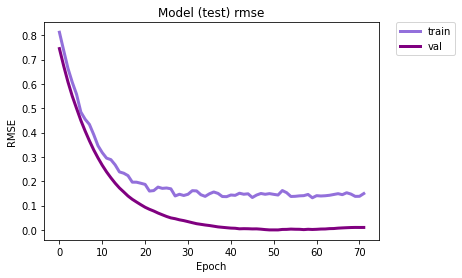

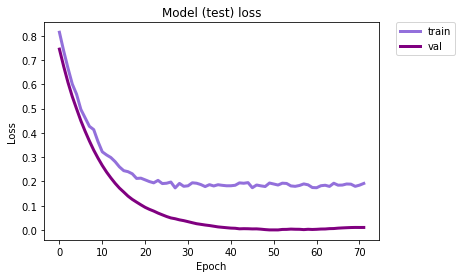

Epoch 1/300
5/5 [==============================] - 0s 83ms/step - loss: 0.1596 - mae: 0.0983 - rmse: 0.1523 - val_loss: 0.3233 - val_mae: 0.1606 - val_rmse: 0.3233
Epoch 2/300
5/5 [==============================] - 0s 58ms/step - loss: 0.1601 - mae: 0.0965 - rmse: 0.1495 - val_loss: 0.3232 - val_mae: 0.1604 - val_rmse: 0.3232
Epoch 3/300
5/5 [==============================] - 0s 98ms/step - loss: 0.1606 - mae: 0.0958 - rmse: 0.1530 - val_loss: 0.3232 - val_mae: 0.1601 - val_rmse: 0.3232
Epoch 4/300
5/5 [==============================] - 1s 90ms/step - loss: 0.1577 - mae: 0.0934 - rmse: 0.1493 - val_loss: 0.3232 - val_mae: 0.1600 - val_rmse: 0.3232
Epoch 5/300
5/5 [==============================] - 0s 75ms/step - loss: 0.1559 - mae: 0.0890 - rmse: 0.1472 - val_loss: 0.3232 - val_mae: 0.1598 - val_rmse: 0.3232
Epoch 6/300
5/5 [==============================] - 1s 124ms/step - loss: 0.1606 - mae: 0.0974 - rmse: 0.1540 - val_loss: 0.3232 - val_mae: 0.1595 - val_rmse: 0.3232
Epoch 7/300
5/5

Epoch 51/300
5/5 [==============================] - 0s 97ms/step - loss: 0.1620 - mae: 0.0927 - rmse: 0.1528 - val_loss: 0.3230 - val_mae: 0.1517 - val_rmse: 0.3230
Epoch 52/300
5/5 [==============================] - 0s 53ms/step - loss: 0.1587 - mae: 0.0891 - rmse: 0.1467 - val_loss: 0.3230 - val_mae: 0.1517 - val_rmse: 0.3230
Epoch 53/300
5/5 [==============================] - 0s 51ms/step - loss: 0.1558 - mae: 0.0896 - rmse: 0.1467 - val_loss: 0.3230 - val_mae: 0.1515 - val_rmse: 0.3230
Epoch 54/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1635 - mae: 0.0939 - rmse: 0.1506 - val_loss: 0.3230 - val_mae: 0.1514 - val_rmse: 0.3230
Epoch 55/300
5/5 [==============================] - 0s 54ms/step - loss: 0.1592 - mae: 0.0901 - rmse: 0.1482 - val_loss: 0.3230 - val_mae: 0.1513 - val_rmse: 0.3230
Epoch 56/300
5/5 [==============================] - 0s 54ms/step - loss: 0.1603 - mae: 0.0926 - rmse: 0.1480 - val_loss: 0.3230 - val_mae: 0.1512 - val_rmse: 0.3230
Epoch 57/3

5/5 [==============================] - 0s 94ms/step - loss: 0.1643 - mae: 0.0903 - rmse: 0.1533 - val_loss: 0.3230 - val_mae: 0.1468 - val_rmse: 0.3230
Epoch 101/300
5/5 [==============================] - 0s 84ms/step - loss: 0.1653 - mae: 0.0943 - rmse: 0.1535 - val_loss: 0.3230 - val_mae: 0.1467 - val_rmse: 0.3230
Epoch 102/300
5/5 [==============================] - 0s 69ms/step - loss: 0.1584 - mae: 0.0877 - rmse: 0.1444 - val_loss: 0.3230 - val_mae: 0.1466 - val_rmse: 0.3230
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


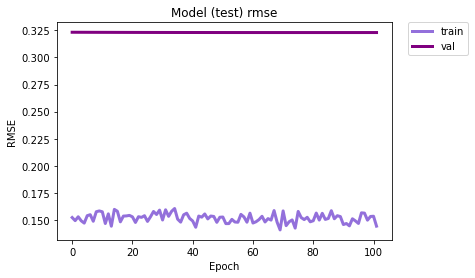

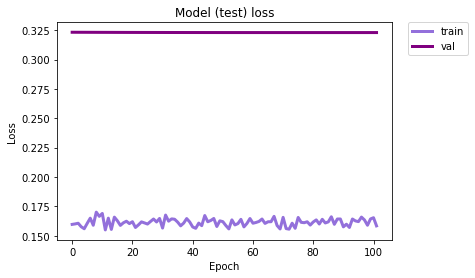

Epoch 1/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1973 - mae: 0.1055 - rmse: 0.2069 - val_loss: 0.2215 - val_mae: 0.1436 - val_rmse: 0.1569
Epoch 2/300
7/7 [==============================] - 0s 54ms/step - loss: 0.1926 - mae: 0.0998 - rmse: 0.2038 - val_loss: 0.2215 - val_mae: 0.1436 - val_rmse: 0.1569
Epoch 3/300
7/7 [==============================] - 0s 60ms/step - loss: 0.1935 - mae: 0.1043 - rmse: 0.2065 - val_loss: 0.2215 - val_mae: 0.1436 - val_rmse: 0.1569
Epoch 4/300
7/7 [==============================] - 0s 59ms/step - loss: 0.1895 - mae: 0.1032 - rmse: 0.2012 - val_loss: 0.2215 - val_mae: 0.1437 - val_rmse: 0.1570
Epoch 5/300
7/7 [==============================] - 0s 73ms/step - loss: 0.1951 - mae: 0.1043 - rmse: 0.2050 - val_loss: 0.2215 - val_mae: 0.1437 - val_rmse: 0.1570
Epoch 6/300
7/7 [==============================] - 0s 67ms/step - loss: 0.1943 - mae: 0.1021 - rmse: 0.2056 - val_loss: 0.2215 - val_mae: 0.1437 - val_rmse: 0.1570
Epoch 7/300
7/7 

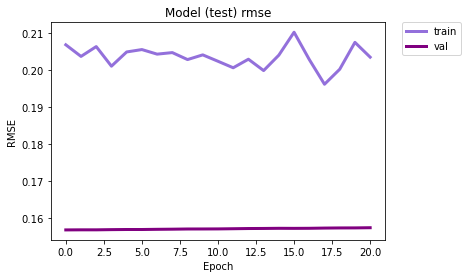

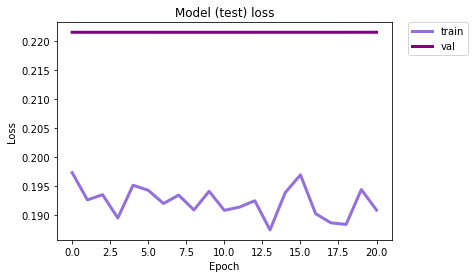

Epoch 1/300
9/9 [==============================] - 1s 69ms/step - loss: 0.1839 - mae: 0.1051 - rmse: 0.1775 - val_loss: 0.2041 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 2/300
9/9 [==============================] - 1s 77ms/step - loss: 0.1867 - mae: 0.1046 - rmse: 0.1788 - val_loss: 0.2040 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 3/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1876 - mae: 0.1069 - rmse: 0.1783 - val_loss: 0.2040 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 4/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1878 - mae: 0.1072 - rmse: 0.1803 - val_loss: 0.2040 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 5/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1933 - mae: 0.1098 - rmse: 0.1854 - val_loss: 0.2040 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 6/300
9/9 [==============================] - 1s 76ms/step - loss: 0.1864 - mae: 0.1037 - rmse: 0.1773 - val_loss: 0.2040 - val_mae: 0.1103 - val_rmse: 0.2900
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1868 - mae: 0.1042 - rmse: 0.1778 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 52/300
9/9 [==============================] - 1s 66ms/step - loss: 0.1875 - mae: 0.0996 - rmse: 0.1793 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 53/300
9/9 [==============================] - 1s 67ms/step - loss: 0.1865 - mae: 0.1027 - rmse: 0.1794 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 54/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1863 - mae: 0.0999 - rmse: 0.1786 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 55/300
9/9 [==============================] - 1s 66ms/step - loss: 0.1874 - mae: 0.1056 - rmse: 0.1793 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 56/300
9/9 [==============================] - 1s 74ms/step - loss: 0.1875 - mae: 0.1055 - rmse: 0.1806 - val_loss: 0.2035 - val_mae: 0.1104 - val_rmse: 0.2900
Epoch 57/3

Epoch 101/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1872 - mae: 0.1013 - rmse: 0.1786 - val_loss: 0.2033 - val_mae: 0.1104 - val_rmse: 0.2901
Epoch 102/300
9/9 [==============================] - 1s 72ms/step - loss: 0.1902 - mae: 0.1041 - rmse: 0.1821 - val_loss: 0.2033 - val_mae: 0.1104 - val_rmse: 0.2901
Epoch 103/300
9/9 [==============================] - 1s 66ms/step - loss: 0.1880 - mae: 0.1023 - rmse: 0.1797 - val_loss: 0.2033 - val_mae: 0.1104 - val_rmse: 0.2901
Epoch 104/300
9/9 [==============================] - 1s 69ms/step - loss: 0.1880 - mae: 0.1046 - rmse: 0.1798 - val_loss: 0.2033 - val_mae: 0.1104 - val_rmse: 0.2901
Epoch 105/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1908 - mae: 0.1060 - rmse: 0.1827 - val_loss: 0.2033 - val_mae: 0.1104 - val_rmse: 0.2901
Epoch 106/300
9/9 [==============================] - 1s 77ms/step - loss: 0.1882 - mae: 0.1016 - rmse: 0.1798 - val_loss: 0.2033 - val_mae: 0.1105 - val_rmse: 0.2901
Epoc

9/9 [==============================] - 1s 60ms/step - loss: 0.1895 - mae: 0.1039 - rmse: 0.1801 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 151/300
9/9 [==============================] - 1s 57ms/step - loss: 0.1879 - mae: 0.1064 - rmse: 0.1795 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 152/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1889 - mae: 0.1042 - rmse: 0.1808 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 153/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1862 - mae: 0.1025 - rmse: 0.1773 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 154/300
9/9 [==============================] - 1s 58ms/step - loss: 0.1880 - mae: 0.0995 - rmse: 0.1792 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 155/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1880 - mae: 0.1021 - rmse: 0.1784 - val_loss: 0.2032 - val_mae: 0.1105 - val_rmse: 0.2902
Epoch 156/300
9/9 

9/9 [==============================] - 1s 77ms/step - loss: 0.1892 - mae: 0.1055 - rmse: 0.1820 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 200/300
9/9 [==============================] - 1s 71ms/step - loss: 0.1875 - mae: 0.1011 - rmse: 0.1782 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 201/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1879 - mae: 0.1030 - rmse: 0.1792 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 202/300
9/9 [==============================] - 1s 77ms/step - loss: 0.1871 - mae: 0.1013 - rmse: 0.1781 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 203/300
9/9 [==============================] - 1s 75ms/step - loss: 0.1866 - mae: 0.1037 - rmse: 0.1770 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 204/300
9/9 [==============================] - 1s 95ms/step - loss: 0.1872 - mae: 0.1039 - rmse: 0.1799 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 205/300
9/9 

9/9 [==============================] - 1s 116ms/step - loss: 0.1844 - mae: 0.0989 - rmse: 0.1738 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 249/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1867 - mae: 0.0987 - rmse: 0.1765 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 250/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1846 - mae: 0.0987 - rmse: 0.1755 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 251/300
9/9 [==============================] - 1s 122ms/step - loss: 0.1874 - mae: 0.1014 - rmse: 0.1780 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 252/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1893 - mae: 0.1041 - rmse: 0.1814 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 253/300
9/9 [==============================] - 1s 74ms/step - loss: 0.1872 - mae: 0.1042 - rmse: 0.1795 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 254/300
9/

9/9 [==============================] - 1s 145ms/step - loss: 0.1893 - mae: 0.1023 - rmse: 0.1825 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 298/300
9/9 [==============================] - 1s 107ms/step - loss: 0.1874 - mae: 0.1011 - rmse: 0.1787 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 299/300
9/9 [==============================] - 1s 113ms/step - loss: 0.1884 - mae: 0.1004 - rmse: 0.1789 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
Epoch 300/300
9/9 [==============================] - 1s 109ms/step - loss: 0.1891 - mae: 0.1031 - rmse: 0.1809 - val_loss: 0.2031 - val_mae: 0.1105 - val_rmse: 0.2903
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


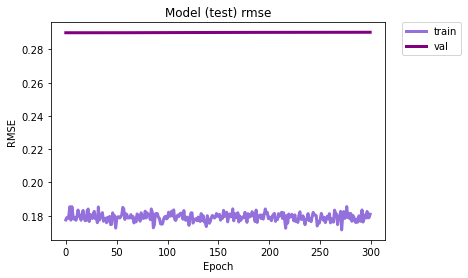

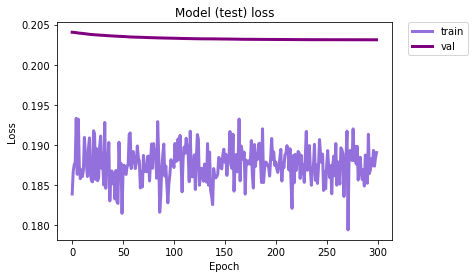

Epoch 1/300
11/11 [==============================] - 1s 136ms/step - loss: 0.1938 - mae: 0.1038 - rmse: 0.1849 - val_loss: 0.3804 - val_mae: 0.1952 - val_rmse: 0.3824
Epoch 2/300
11/11 [==============================] - 1s 87ms/step - loss: 0.1897 - mae: 0.0986 - rmse: 0.1815 - val_loss: 0.3804 - val_mae: 0.1952 - val_rmse: 0.3824
Epoch 3/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1927 - mae: 0.0994 - rmse: 0.1836 - val_loss: 0.3804 - val_mae: 0.1952 - val_rmse: 0.3823
Epoch 4/300
11/11 [==============================] - 1s 78ms/step - loss: 0.1906 - mae: 0.1005 - rmse: 0.1819 - val_loss: 0.3804 - val_mae: 0.1952 - val_rmse: 0.3823
Epoch 5/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1933 - mae: 0.1032 - rmse: 0.1846 - val_loss: 0.3803 - val_mae: 0.1952 - val_rmse: 0.3823
Epoch 6/300
11/11 [==============================] - 1s 79ms/step - loss: 0.1900 - mae: 0.1000 - rmse: 0.1816 - val_loss: 0.3803 - val_mae: 0.1952 - val_rmse: 0.3823
Epo

11/11 [==============================] - 1s 85ms/step - loss: 0.1899 - mae: 0.1027 - rmse: 0.1813 - val_loss: 0.3796 - val_mae: 0.1961 - val_rmse: 0.3816
Epoch 51/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1906 - mae: 0.0991 - rmse: 0.1810 - val_loss: 0.3796 - val_mae: 0.1961 - val_rmse: 0.3816
Epoch 52/300
11/11 [==============================] - 1s 80ms/step - loss: 0.1906 - mae: 0.1017 - rmse: 0.1817 - val_loss: 0.3795 - val_mae: 0.1962 - val_rmse: 0.3815
Epoch 53/300
11/11 [==============================] - 1s 81ms/step - loss: 0.1932 - mae: 0.1024 - rmse: 0.1847 - val_loss: 0.3796 - val_mae: 0.1962 - val_rmse: 0.3815
Epoch 54/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1909 - mae: 0.1014 - rmse: 0.1820 - val_loss: 0.3795 - val_mae: 0.1962 - val_rmse: 0.3815
Epoch 55/300
11/11 [==============================] - 1s 89ms/step - loss: 0.1909 - mae: 0.0995 - rmse: 0.1822 - val_loss: 0.3795 - val_mae: 0.1962 - val_rmse: 0.3815
Epoch 56/30

Epoch 99/300
11/11 [==============================] - 1s 83ms/step - loss: 0.1928 - mae: 0.1039 - rmse: 0.1840 - val_loss: 0.3792 - val_mae: 0.1966 - val_rmse: 0.3812
Epoch 100/300
11/11 [==============================] - 1s 79ms/step - loss: 0.1898 - mae: 0.0965 - rmse: 0.1816 - val_loss: 0.3792 - val_mae: 0.1967 - val_rmse: 0.3812
Epoch 101/300
11/11 [==============================] - 1s 101ms/step - loss: 0.1916 - mae: 0.1026 - rmse: 0.1834 - val_loss: 0.3792 - val_mae: 0.1967 - val_rmse: 0.3812
Epoch 102/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1919 - mae: 0.1029 - rmse: 0.1829 - val_loss: 0.3791 - val_mae: 0.1967 - val_rmse: 0.3811
Epoch 103/300
11/11 [==============================] - 1s 92ms/step - loss: 0.1929 - mae: 0.1029 - rmse: 0.1835 - val_loss: 0.3791 - val_mae: 0.1967 - val_rmse: 0.3811
Epoch 104/300
11/11 [==============================] - 1s 98ms/step - loss: 0.1908 - mae: 0.0990 - rmse: 0.1815 - val_loss: 0.3791 - val_mae: 0.1968 - val_rmse:

11/11 [==============================] - 1s 105ms/step - loss: 0.1934 - mae: 0.1028 - rmse: 0.1836 - val_loss: 0.3790 - val_mae: 0.1969 - val_rmse: 0.3810
Epoch 148/300
11/11 [==============================] - 1s 138ms/step - loss: 0.1877 - mae: 0.0978 - rmse: 0.1791 - val_loss: 0.3790 - val_mae: 0.1969 - val_rmse: 0.3810
Epoch 149/300
11/11 [==============================] - 2s 177ms/step - loss: 0.1901 - mae: 0.0986 - rmse: 0.1820 - val_loss: 0.3790 - val_mae: 0.1969 - val_rmse: 0.3810
Epoch 150/300
11/11 [==============================] - 1s 135ms/step - loss: 0.1914 - mae: 0.1009 - rmse: 0.1837 - val_loss: 0.3790 - val_mae: 0.1969 - val_rmse: 0.3810
Epoch 151/300
11/11 [==============================] - 1s 101ms/step - loss: 0.1903 - mae: 0.0991 - rmse: 0.1813 - val_loss: 0.3790 - val_mae: 0.1969 - val_rmse: 0.3810
Epoch 152/300
11/11 [==============================] - 1s 98ms/step - loss: 0.1941 - mae: 0.1019 - rmse: 0.1850 - val_loss: 0.3791 - val_mae: 0.1969 - val_rmse: 0.3811
E

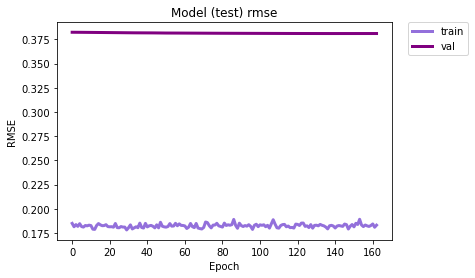

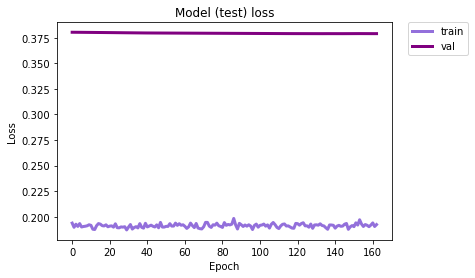

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.92549276
Transformed yhat 64.20234
yhat 0.92568904
Transformed yhat 64.20444
yhat 0.9259223
Transformed yhat 64.20693
yhat 0.9261746
Transformed yhat 64.20963
yhat 0.9264338
Transformed yhat 64.21241
yhat 0.92669123
Transformed yhat 64.215164
yhat 0.9269407
Transformed yhat 64.217834
yhat 0.9272376
Transformed yhat 64.221016
yhat 0.928348
Transformed yhat 64.2329
yhat 0.9287315
Transformed yhat 64.23701
yhat 0.9288735
Transformed yhat 64.238525
yhat 0.92900723
Transformed yhat 64.23996
Real data: [65.         65.         65.         65.         65.         65.
 64.41176471 55.78846154 61.88235294 64.         64.         64.
 64.         64.         64.         64.         64.         64.
 64.         64.         64.         64.         64.         64.        ]
Forecasting values: [64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2, 64.2]


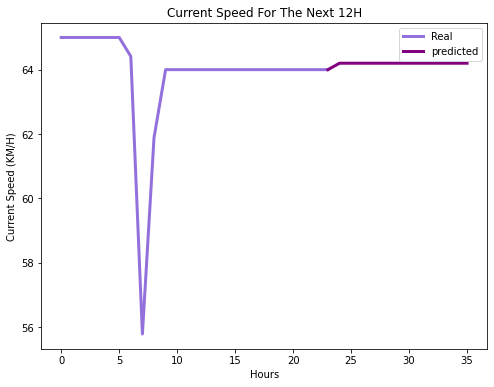

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.1',forecastSpeed[i],hour[i]
        writer.writerow(d)